# Parameter Initialization

In [1]:
import torch
import torchsummary
import torchvision

from matplotlib import pyplot as plt

## Constants

In [2]:
BATCH_SIZE = 128
LEARNING_RATE = 0.001
N_EPOCHS = 10
TRAIN_VAL_SPLIT = [55000, 5000]

## Loading the Data

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)),
])

train_set = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform,
)

train_set, val_set = torch.utils.data.random_split(train_set, TRAIN_VAL_SPLIT)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)

## Defining the model

In [4]:
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=1,
                out_channels=7,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            torch.nn.Tanh(),
            torch.nn.Conv2d(
                in_channels=7,
                out_channels=19,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            torch.nn.Tanh(),
            torch.nn.Conv2d(
                in_channels=19,
                out_channels=31,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            torch.nn.Tanh(),
            torch.nn.Flatten(),
            torch.nn.Linear(
                in_features=31*32*32,
                out_features=1024,
            ),
            torch.nn.Tanh(),
            torch.nn.Linear(
                in_features=1024,
                out_features=10,
            )
        )

    
    def forward(self, x):
        return self.network(x)

In [5]:
model = Model()

torchsummary.summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 7, 32, 32]              70
              Tanh-2            [-1, 7, 32, 32]               0
            Conv2d-3           [-1, 19, 32, 32]           1,216
              Tanh-4           [-1, 19, 32, 32]               0
            Conv2d-5           [-1, 31, 32, 32]           5,332
              Tanh-6           [-1, 31, 32, 32]               0
           Flatten-7                [-1, 31744]               0
            Linear-8                 [-1, 1024]      32,506,880
              Tanh-9                 [-1, 1024]               0
           Linear-10                   [-1, 10]          10,250
Total params: 32,523,748
Trainable params: 32,523,748
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.15
Params size (MB): 124.07
Est

In [6]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Baseline

In [7]:
def fit(model):

    accuracy_hist = []
    loss_hist = []
    val_accuracy_hist = []
    val_los_hist = []

    for epoch in range(N_EPOCHS):
        training_cost = 0.0
        training_correct = 0.0
        validation_cost = 0.0
        validation_correct = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            predictions = model(inputs)
            cost = loss_func(predictions, targets)
            cost.backward()
            optimizer.step()
            training_cost += cost.item()
            training_correct += (torch.argmax(predictions, dim=1) == targets).sum()
        training_cost /= len(train_set)
        training_correct /= len(train_set)
        print(f'epoch: {epoch}, loss: {training_cost}, accuracy: {training_correct}')
        accuracy_hist.append(training_correct)
        loss_hist.append(training_cost)

        with torch.no_grad():
            for inputs, targets in val_loader:
                predictions = model(inputs)
                cost = loss_func(predictions, targets)
                validation_cost += cost.item()
                validation_correct += (torch.argmax(predictions, dim=1) == targets).sum()
            validation_cost /= len(val_set)
            validation_correct /= len(val_set)
            print(f'Validation: loss: {validation_cost}, accuracy: {validation_correct}')
            val_accuracy_hist.append(validation_correct)
            val_los_hist.append(validation_cost)

    return accuracy_hist, loss_hist, val_accuracy_hist, val_los_hist

In [8]:
accuracy_hist, loss_hist, val_accuracy_hist, val_los_hist = fit(model)

epoch: 0, loss: 0.005528987060351805, accuracy: 0.7490727305412292
Validation: loss: 0.004795952171087265, accuracy: 0.7778000235557556
epoch: 1, loss: 0.004170327956026251, accuracy: 0.8037818074226379
Validation: loss: 0.003979349440336228, accuracy: 0.8155999779701233
epoch: 2, loss: 0.004049574426087466, accuracy: 0.8098000288009644
Validation: loss: 0.0041219291806221005, accuracy: 0.8123999834060669
epoch: 3, loss: 0.0039361973534930835, accuracy: 0.8147090673446655
Validation: loss: 0.004024724632501602, accuracy: 0.8141999840736389
epoch: 4, loss: 0.003861742252382365, accuracy: 0.8206363916397095
Validation: loss: 0.0039069688647985455, accuracy: 0.8216000199317932
epoch: 5, loss: 0.0038807193674824454, accuracy: 0.817799985408783
Validation: loss: 0.003826366984844208, accuracy: 0.8194000124931335
epoch: 6, loss: 0.003807033649899743, accuracy: 0.822490930557251
Validation: loss: 0.003976690530776978, accuracy: 0.8203999996185303
epoch: 7, loss: 0.0038148709226738325, accurac

## Training Visualization

In [9]:
def plot(accuracy_hist, loss_hist, val_accuracy_hist, val_los_hist):
    f = plt.figure(figsize=(18, 6))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.plot(accuracy_hist, label='Training')
    ax1.plot(val_accuracy_hist, label='Validation')
    ax1.title.set_text('Accuracy')
    ax1.legend()
    ax1.grid()
    ax2.plot(loss_hist, label='Training')
    ax2.plot(val_los_hist, label='Validation')
    ax2.title.set_text('Loss')
    ax2.legend()
    ax2.grid()

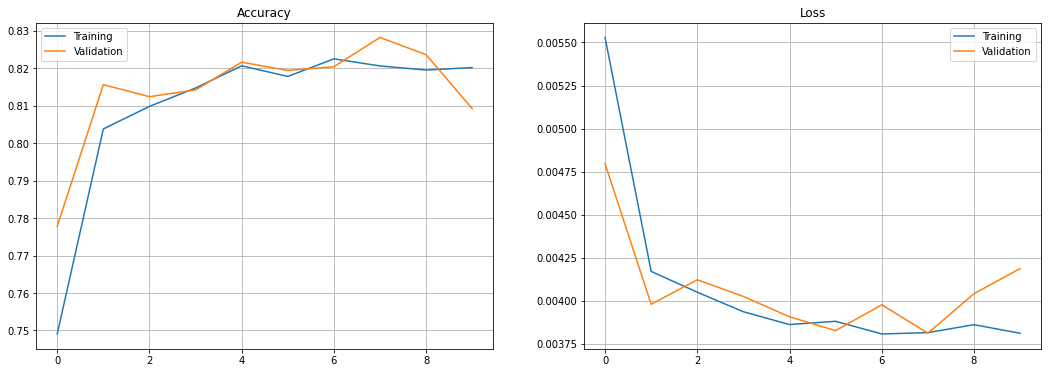

In [10]:
plot(accuracy_hist, loss_hist, val_accuracy_hist, val_los_hist)

## Manually initialize the weights

### Kaiming He ReLU 0 Bias

In [11]:
def initialize_weights(layer):
    if isinstance(layer, torch.nn.Conv2d):
        torch.nn.init.kaiming_uniform_(layer.weight.data, nonlinearity='relu')
        if layer.bias is not None:
            torch.nn.init.constant_(layer.bias.data, 0)
    elif isinstance(layer, torch.nn.Linear):
        torch.nn.init.kaiming_uniform_(layer.weight.data)
        torch.nn.init.constant_(layer.bias.data, 0)

In [12]:
model = Model()
model.apply(initialize_weights)

Model(
  (network): Sequential(
    (0): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): Conv2d(7, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Tanh()
    (4): Conv2d(19, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Tanh()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=31744, out_features=1024, bias=True)
    (8): Tanh()
    (9): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [13]:
he_accuracy_hist, he_loss_hist, he_val_accuracy_hist, he_val_los_hist = fit(model)

epoch: 0, loss: 0.021166098282553933, accuracy: 0.09120000153779984
Validation: loss: 0.021580863952636718, accuracy: 0.09200000017881393
epoch: 1, loss: 0.021161535436456852, accuracy: 0.09138181805610657
Validation: loss: 0.02165660424232483, accuracy: 0.08839999884366989
epoch: 2, loss: 0.021168476724624633, accuracy: 0.09116363525390625
Validation: loss: 0.021630642700195313, accuracy: 0.09300000220537186
epoch: 3, loss: 0.02115881509780884, accuracy: 0.09025454521179199
Validation: loss: 0.021622769594192504, accuracy: 0.09560000151395798
epoch: 4, loss: 0.02115364010550759, accuracy: 0.09196363389492035
Validation: loss: 0.021710323190689086, accuracy: 0.09019999951124191
epoch: 5, loss: 0.021144751687483355, accuracy: 0.09158182144165039
Validation: loss: 0.02166066780090332, accuracy: 0.0957999974489212
epoch: 6, loss: 0.021151697145808827, accuracy: 0.09185454249382019
Validation: loss: 0.021569828128814698, accuracy: 0.09000000357627869
epoch: 7, loss: 0.021147279713370583, a

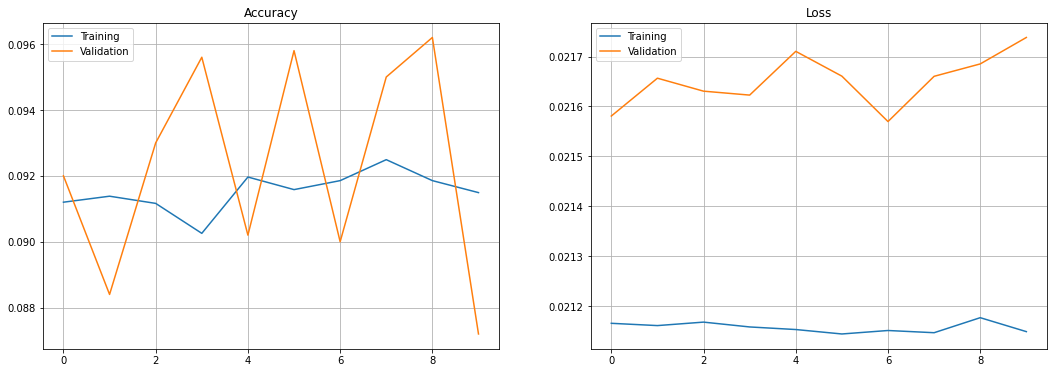

In [14]:
plot(he_accuracy_hist, he_loss_hist, he_val_accuracy_hist, he_val_los_hist)

### 0 Weights 0 Bias

In [15]:
def initialize_weights(layer):
    if isinstance(layer, torch.nn.Conv2d):
        torch.nn.init.constant_(layer.weight.data, 0)
        if layer.bias is not None:
            torch.nn.init.constant_(layer.bias.data, 0)
    elif isinstance(layer, torch.nn.Linear):
        torch.nn.init.constant_(layer.weight.data, 0)
        torch.nn.init.constant_(layer.bias.data, 0)

In [16]:
model = Model()
model.apply(initialize_weights)

Model(
  (network): Sequential(
    (0): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): Conv2d(7, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Tanh()
    (4): Conv2d(19, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Tanh()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=31744, out_features=1024, bias=True)
    (8): Tanh()
    (9): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [17]:
zero_accuracy_hist, zero_loss_hist, zero_val_accuracy_hist, zero_val_los_hist = fit(model)

epoch: 0, loss: 0.018002031022852118, accuracy: 0.10040000081062317
Validation: loss: 0.018420682907104493, accuracy: 0.09560000151395798
epoch: 1, loss: 0.018002031022852118, accuracy: 0.10040000081062317
Validation: loss: 0.018420682907104493, accuracy: 0.09560000151395798
epoch: 2, loss: 0.018002031022852118, accuracy: 0.10040000081062317
Validation: loss: 0.018420682907104493, accuracy: 0.09560000151395798
epoch: 3, loss: 0.018002031022852118, accuracy: 0.10040000081062317
Validation: loss: 0.018420682907104493, accuracy: 0.09560000151395798
epoch: 4, loss: 0.018002031022852118, accuracy: 0.10040000081062317
Validation: loss: 0.018420682907104493, accuracy: 0.09560000151395798
epoch: 5, loss: 0.018002031022852118, accuracy: 0.10040000081062317
Validation: loss: 0.018420682907104493, accuracy: 0.09560000151395798
epoch: 6, loss: 0.018002031022852118, accuracy: 0.10040000081062317
Validation: loss: 0.018420682907104493, accuracy: 0.09560000151395798
epoch: 7, loss: 0.0180020310228521

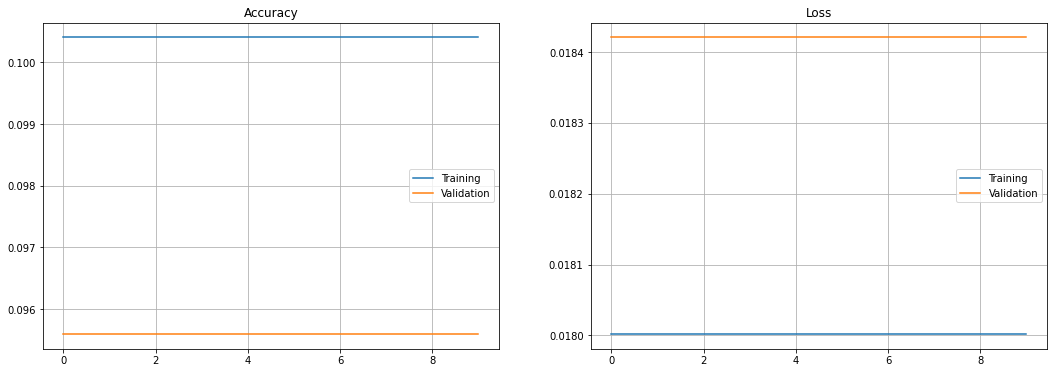

In [18]:
plot(zero_accuracy_hist, zero_loss_hist, zero_val_accuracy_hist, zero_val_los_hist)

### Standard normal Weights 0 Bias

In [19]:
def initialize_weights(layer):
    if isinstance(layer, torch.nn.Conv2d):
        torch.nn.init.normal_(layer.weight.data)
        if layer.bias is not None:
            torch.nn.init.constant_(layer.bias.data, 0)
    elif isinstance(layer, torch.nn.Linear):
        torch.nn.init.normal_(layer.weight.data)
        torch.nn.init.constant_(layer.bias.data, 0)

In [20]:
model = Model()
model.apply(initialize_weights)

Model(
  (network): Sequential(
    (0): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): Conv2d(7, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Tanh()
    (4): Conv2d(19, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Tanh()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=31744, out_features=1024, bias=True)
    (8): Tanh()
    (9): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [21]:
normal_accuracy_hist, normal_loss_hist, normal_val_accuracy_hist, normal_val_los_hist = fit(model)

epoch: 0, loss: 0.4357828622991389, accuracy: 0.12349090725183487
Validation: loss: 0.45367901077270506, accuracy: 0.12860000133514404
epoch: 1, loss: 0.4354830940246582, accuracy: 0.12467272579669952
Validation: loss: 0.4474960037231445, accuracy: 0.12060000002384186
epoch: 2, loss: 0.4361028378573331, accuracy: 0.12296363711357117
Validation: loss: 0.4503395408630371, accuracy: 0.11760000139474869
epoch: 3, loss: 0.43388982308127666, accuracy: 0.1258181780576706
Validation: loss: 0.44483531799316406, accuracy: 0.11779999732971191
epoch: 4, loss: 0.43609947058937765, accuracy: 0.12487272918224335
Validation: loss: 0.44295225982666014, accuracy: 0.11760000139474869
epoch: 5, loss: 0.4371989884810014, accuracy: 0.12380000203847885
Validation: loss: 0.4460485908508301, accuracy: 0.12439999729394913
epoch: 6, loss: 0.43569567232998935, accuracy: 0.12380000203847885
Validation: loss: 0.4524687889099121, accuracy: 0.11980000138282776
epoch: 7, loss: 0.4357114066384055, accuracy: 0.124109089

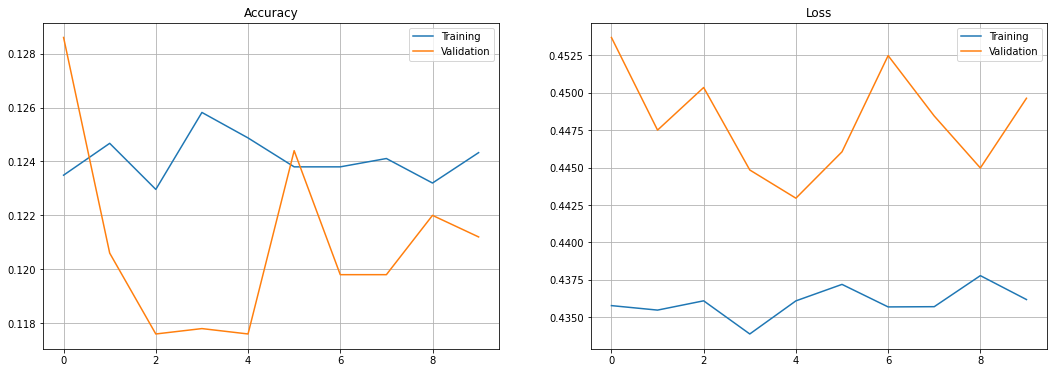

In [22]:
plot(normal_accuracy_hist, normal_loss_hist, normal_val_accuracy_hist, normal_val_los_hist)

### Uniform Weights 0 Bias

In [23]:
def initialize_weights(layer):
    if isinstance(layer, torch.nn.Conv2d):
        torch.nn.init.uniform_(layer.weight.data)
        if layer.bias is not None:
            torch.nn.init.constant_(layer.bias.data, 0)
    elif isinstance(layer, torch.nn.Linear):
        torch.nn.init.uniform_(layer.weight.data)
        torch.nn.init.constant_(layer.bias.data, 0)

In [24]:
model = Model()
model.apply(initialize_weights)

Model(
  (network): Sequential(
    (0): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): Conv2d(7, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Tanh()
    (4): Conv2d(19, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Tanh()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=31744, out_features=1024, bias=True)
    (8): Tanh()
    (9): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [25]:
uni_accuracy_hist, uni_loss_hist, uni_val_accuracy_hist, uni_val_los_hist = fit(model)

epoch: 0, loss: 0.1368066108010032, accuracy: 0.11292727291584015
Validation: loss: 0.14139105167388916, accuracy: 0.10819999873638153
epoch: 1, loss: 0.13683734550476073, accuracy: 0.11321818083524704
Validation: loss: 0.14102720165252686, accuracy: 0.10740000009536743
epoch: 2, loss: 0.13687884186831387, accuracy: 0.11309091001749039
Validation: loss: 0.14070413188934325, accuracy: 0.1088000014424324
epoch: 3, loss: 0.13686841916170986, accuracy: 0.11310908943414688
Validation: loss: 0.13968101329803467, accuracy: 0.10859999805688858
epoch: 4, loss: 0.1368788676001809, accuracy: 0.11314545571804047
Validation: loss: 0.1403612470626831, accuracy: 0.1080000028014183
epoch: 5, loss: 0.13686356374567205, accuracy: 0.11301818490028381
Validation: loss: 0.13999564590454103, accuracy: 0.10639999806880951
epoch: 6, loss: 0.13682947720614347, accuracy: 0.11316363513469696
Validation: loss: 0.13976118144989014, accuracy: 0.10819999873638153
epoch: 7, loss: 0.13675968319286, accuracy: 0.1133272

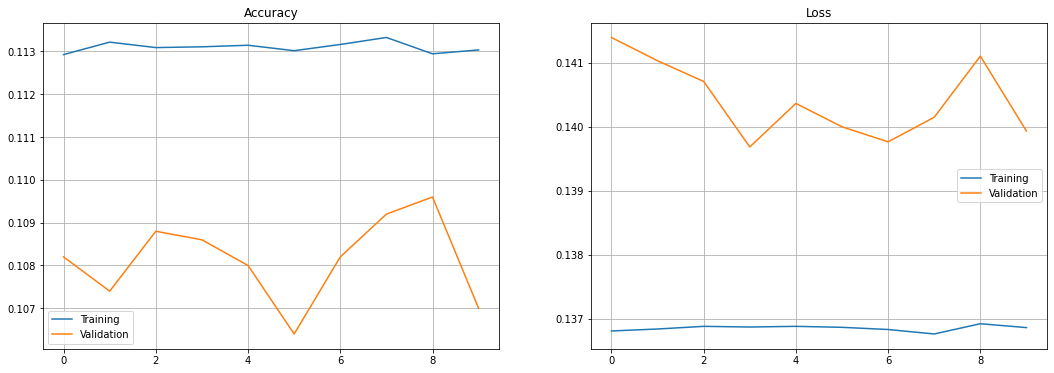

In [26]:
plot(uni_accuracy_hist, uni_loss_hist, uni_val_accuracy_hist, uni_val_los_hist)

### Xavier Glorot Tanh 0 Bias

In [27]:
def initialize_weights(layer):
    if isinstance(layer, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform_(layer.weight.data, torch.nn.init.calculate_gain('tanh'))
        if layer.bias is not None:
            torch.nn.init.constant_(layer.bias.data, 0)
    elif isinstance(layer, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight.data)
        torch.nn.init.constant_(layer.bias.data, 0)

In [28]:
model = Model()
model.apply(initialize_weights)

Model(
  (network): Sequential(
    (0): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): Conv2d(7, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Tanh()
    (4): Conv2d(19, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Tanh()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=31744, out_features=1024, bias=True)
    (8): Tanh()
    (9): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [29]:
glo_accuracy_hist, glo_loss_hist, glo_val_accuracy_hist, glo_val_los_hist = fit(model)

epoch: 0, loss: 0.01987760281129317, accuracy: 0.08072727173566818
Validation: loss: 0.02028241672515869, accuracy: 0.08839999884366989
epoch: 1, loss: 0.019878635488856922, accuracy: 0.08143636584281921
Validation: loss: 0.02023668828010559, accuracy: 0.08460000157356262
epoch: 2, loss: 0.019868218218196523, accuracy: 0.08170909434556961
Validation: loss: 0.02013390636444092, accuracy: 0.08100000023841858
epoch: 3, loss: 0.019904915207082576, accuracy: 0.08107272535562515
Validation: loss: 0.020258954668045046, accuracy: 0.0812000036239624
epoch: 4, loss: 0.019852868977459994, accuracy: 0.08283636718988419
Validation: loss: 0.020266303205490114, accuracy: 0.08760000020265579
epoch: 5, loss: 0.019880191746625035, accuracy: 0.08323636651039124
Validation: loss: 0.02011757183074951, accuracy: 0.08079999685287476
epoch: 6, loss: 0.01988043849251487, accuracy: 0.0817272737622261
Validation: loss: 0.020322974061965943, accuracy: 0.08699999749660492
epoch: 7, loss: 0.019854990525679156, accu

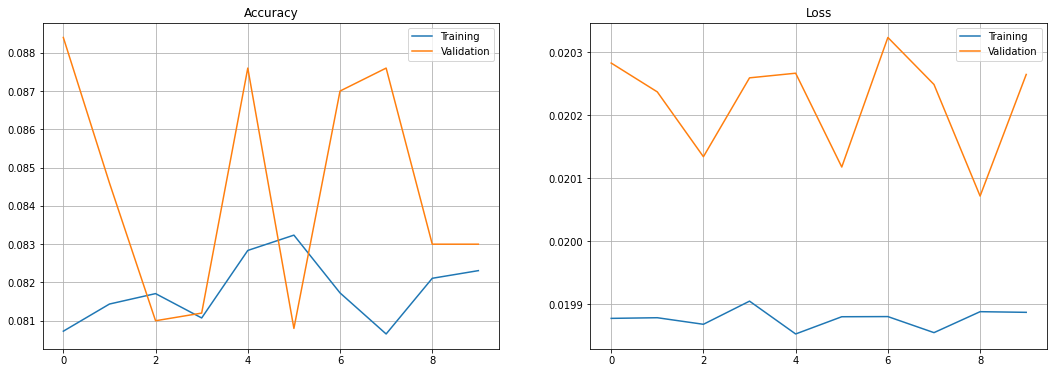

In [30]:
plot(glo_accuracy_hist, glo_loss_hist, glo_val_accuracy_hist, glo_val_los_hist)

## Comparison

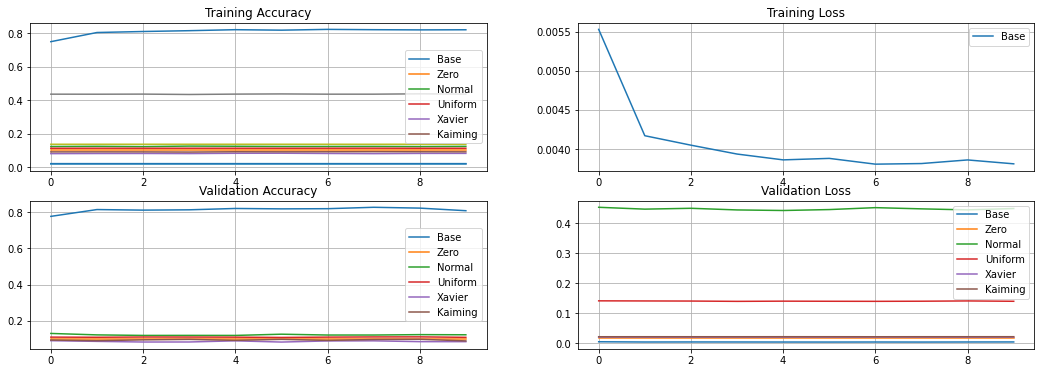

In [31]:
f = plt.figure(figsize=(18, 6))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)
ax1.plot(accuracy_hist, label='Base')
ax1.plot(zero_accuracy_hist, label='Zero')
ax1.plot(normal_accuracy_hist, label='Normal')
ax1.plot(uni_accuracy_hist, label='Uniform')
ax1.plot(glo_accuracy_hist, label='Xavier')
ax1.plot(he_accuracy_hist, label='Kaiming')
ax1.title.set_text('Training Accuracy')
ax1.legend()
ax1.grid()
ax2.plot(loss_hist, label='Base')
ax1.plot(zero_loss_hist, label='Zero')
ax1.plot(normal_loss_hist, label='Normal')
ax1.plot(uni_loss_hist, label='Uniform')
ax1.plot(glo_loss_hist, label='Xavier')
ax1.plot(he_loss_hist, label='Kaiming')
ax2.title.set_text('Training Loss')
ax2.legend()
ax2.grid()
ax3.plot(val_accuracy_hist, label='Base')
ax3.plot(zero_val_accuracy_hist, label='Zero')
ax3.plot(normal_val_accuracy_hist, label='Normal')
ax3.plot(uni_val_accuracy_hist, label='Uniform')
ax3.plot(glo_val_accuracy_hist, label='Xavier')
ax3.plot(he_val_accuracy_hist, label='Kaiming')
ax3.title.set_text('Validation Accuracy')
ax3.legend()
ax3.grid()
ax4.plot(val_los_hist, label='Base')
ax4.plot(zero_val_los_hist, label='Zero')
ax4.plot(normal_val_los_hist, label='Normal')
ax4.plot(uni_val_los_hist, label='Uniform')
ax4.plot(glo_val_los_hist, label='Xavier')
ax4.plot(he_val_los_hist, label='Kaiming')
ax4.title.set_text('Validation Loss')
ax4.legend()
ax4.grid()